## Import required Python modules

## Download data and pre-proces data

In [6]:
import numpy as np
from matplotlib import pyplot as plt

In [7]:
# NPZ files path
data_path='/home/sandeep/storage/extracted_data/test'

# data file with all the 16310 frames: 'Data_16310.npz'
# data file with only 1000 frames: 'Data_1000.npz'

#data_file='/Data_16310.npz'
data_file = '/Test_Data_5698.npz'
data=np.load(data_path+data_file)

In [8]:
X = np.float32(np.dstack((np.float32(data['arr_0']), np.float32(data['arr_1']), np.float32(data['arr_2']),
                          np.float32(data['arr_3']), np.float32(data['arr_4']), np.float32(data['arr_5']),
                          np.float32(data['arr_6']), np.float32(data['arr_7']), np.float32(data['arr_8']),
                          np.float32(data['arr_19']))))
print(X.shape)
print(X.nbytes)


def strided_app(a, L, S ):  # Window len = L, Stride len/stepsize = S
    nrows = ((a.shape[0]-L)//S)+1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a, shape=(nrows,L,a.shape[1] ), strides=(S*n,n,a.strides[1]))

X2 = []
for i in range (0, X.shape[0]):
    X2.append(strided_app(X[i],500,250))
    
X2 = np.asarray(X2)
X2 = X2.reshape((-1,500,10))
print(X2.shape)
del X



import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Permute, Reshape
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import itertools


z = 0
z1 = 0
X_train0 = X2[z:z1]
X_val0 = X2[:z]
X_test0 = X2[z1:]
print(np.shape(X_train0))
print(np.shape(X_val0))
print(np.shape(X_test0))


def _data_reshaping(X_tr, X_va, X_ts, network_type):
    _, win_len, dim = X_tr.shape
    print(network_type)
    if network_type=='CNN' or network_type=='ConvLSTM':
        
        # make it into (frame_number, dimension, window_size, channel=1) for convNet
        X_tr = np.swapaxes(X_tr,1,2)
        X_va = np.swapaxes(X_va,1,2)
        X_ts = np.swapaxes(X_ts,1,2)

        X_tr = np.reshape(X_tr, (-1, dim, win_len, 1))
        X_va = np.reshape(X_va, (-1, dim, win_len, 1))
        X_ts = np.reshape(X_ts, (-1, dim, win_len, 1))
        
    if network_type=='MLP':
        print('MLP...')
        X_tr = np.reshape(X_tr, (-1, dim*win_len))
        X_va = np.reshape(X_va, (-1, dim*win_len))
        X_ts = np.reshape(X_ts, (-1, dim*win_len))
    
    return X_tr, X_va, X_ts


#network_type = 'CNN'
network_type = 'ConvLSTM'
#network_type = 'LSTM'
#network_type = 'MLP'
_, win_len, dim = X_train0.shape
print(win_len)
print(dim)

X_train, X_val, X_test = _data_reshaping(X_train0, X_val0, X_test0, network_type)

model = load_model('Conv_lstm_bid6_94')
print(model.summary())

(5698, 6000, 10)
1367520000
(131054, 500, 10)


/home/sandeep/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(0, 500, 10)
(0, 500, 10)
(131054, 500, 10)
500
10
ConvLSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 10, 500, 32)       192       
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 500, 32)       128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 250, 32)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 250, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 250, 64)       6208      
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 250, 64)       256       
_________________________________________________________________
max_pooling2d_2 

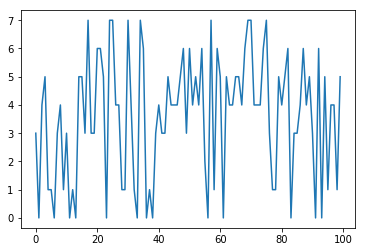

(5698,)
(5698, 6000)
(11396,)
(5698, 6000)


In [9]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_pred2 = np.zeros((int(len(y_pred)/23)))

ind = 0
for i in range (0,len(y_pred), 23):
    (values,counts) = np.unique(y_pred[i:i+23],return_counts=True)
    c = np.argmax(counts)
    y_pred2[ind] = values[c]
    ind = ind+1
plt.figure()
plt.plot(y_pred2[:100])
plt.show()


print(y_pred2.shape)
y_pred2 = np.int8(y_pred2) + 1
y_pred2 = y_pred2.repeat(6000).reshape(-1,6000)
print(y_pred2.shape)

out_path='/home/sandeep/storage/HASCA-Workshop/Vikranth/Predictions/Final_60/'

# data file with all the 16310 frames: 'Data_16310.npz'
# data file with only 1000 frames: 'Data_1000.npz'

out_file='bid6_94'
np.save(out_path + out_file, y_pred2)

y_pred2 = np.zeros((int(len(y_pred)/23)*2))
ind = 0
for i in range (0,len(y_pred), 23):
    (values,counts) = np.unique(y_pred[i:i+14],return_counts=True)
    c = np.argmax(counts)
    y_pred2[ind] = values[c]
    (values,counts) = np.unique(y_pred[i+10:i+23],return_counts=True)
    c = np.argmax(counts)
    y_pred2[ind+1] = values[c]
    ind = ind+2

print(y_pred2.shape)
y_pred2 = np.int8(y_pred2) + 1
y_pred2 = y_pred2.repeat(3000).reshape(-1,6000)
print(y_pred2.shape)


out_path='/home/sandeep/storage/HASCA-Workshop/Vikranth/Predictions/Final_30/'

# data file with all the 16310 frames: 'Data_16310.npz'
# data file with only 1000 frames: 'Data_1000.npz'

out_file='bid6_94'
np.save(out_path + out_file, y_pred2)


In [4]:
X = np.float32(np.dstack((np.float32(data['arr_0']), np.float32(data['arr_1']), np.float32(data['arr_2']),
                          np.float32(data['arr_3']), np.float32(data['arr_4']), np.float32(data['arr_5']),
                          np.float32(data['arr_6']), np.float32(data['arr_7']), np.float32(data['arr_8']),
                          np.float32(data['arr_19']))))
Y = np.int8(data['arr_20'] - 1)
#X = np.float32(X)
#Y = np.int8(Y)
print(X.shape)
print(Y.shape)

(5698, 6000, 10)


In [5]:
print(X.nbytes)
print(Y.nbytes)

1367520000


In [5]:
def strided_app(a, L, S ):  # Window len = L, Stride len/stepsize = S
    nrows = ((a.shape[0]-L)//S)+1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a, shape=(nrows,L,a.shape[1] ), strides=(S*n,n,a.strides[1]))

In [6]:
X2 = []
for i in range (0, X.shape[0]):
    X2.append(strided_app(X[i],500,250))
    
X2 = np.asarray(X2)
X2 = X2.reshape((-1,500,10))
print(X2.shape)
del X

(375130, 500, 10)


In [7]:
Y = np.expand_dims(Y, axis=2)
Y2 = []
for i in range (0, Y.shape[0]):
    Y2.append(strided_app(Y[i],500,250))
    
Y2 = np.asarray(Y2)
Y2 = Y2.reshape((-1,500,1))
print(Y2.shape)
del Y

(375130, 500, 1)


In [8]:
Y2 = Y2[:,0]
print(Y2.shape)

(375130, 1)


## Load the pre-processed data

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Permute, Reshape
from keras import backend as K
from keras.callbacks import ModelCheckpoint

/home/sandeep/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
z = 39997
z1 = 319999
X_train0 = X2[z:z1]
Y_train = Y2[z:z1].reshape(-1).astype(np.uint8)
X_val0 = X2[:z]
Y_val = Y2[:z].reshape(-1).astype(np.uint8)
X_test0 = X2[z1:]
Y_test = Y2[z1:].reshape(-1).astype(np.uint8)
print(np.shape(X_train0))
print(np.shape(Y_train))
print(np.shape(X_val0))
print(np.shape(Y_val))
print(np.shape(X_test0))
print(np.shape(Y_test))

(280002, 500, 10)
(280002,)
(39997, 500, 10)
(39997,)
(55131, 500, 10)
(55131,)


In [11]:
np.random.seed(42)
p = np.random.permutation(Y_train.shape[0])
Y_train = Y_train[p]
X_train0 = X_train0[p,:,:]
print(Y_train.shape)
print(X_train0.shape)

(280002,)
(280002, 500, 10)


In [12]:
num_classes = 8
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_val = keras.utils.to_categorical(Y_val, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

## My Models

In [13]:
def _data_reshaping(X_tr, X_va, X_ts, network_type):
    _, win_len, dim = X_tr.shape
    print(network_type)
    if network_type=='CNN' or network_type=='ConvLSTM':
        
        # make it into (frame_number, dimension, window_size, channel=1) for convNet
        X_tr = np.swapaxes(X_tr,1,2)
        X_va = np.swapaxes(X_va,1,2)
        X_ts = np.swapaxes(X_ts,1,2)

        X_tr = np.reshape(X_tr, (-1, dim, win_len, 1))
        X_va = np.reshape(X_va, (-1, dim, win_len, 1))
        X_ts = np.reshape(X_ts, (-1, dim, win_len, 1))
        
    if network_type=='MLP':
        print('MLP...')
        X_tr = np.reshape(X_tr, (-1, dim*win_len))
        X_va = np.reshape(X_va, (-1, dim*win_len))
        X_ts = np.reshape(X_ts, (-1, dim*win_len))
    
    return X_tr, X_va, X_ts

In [14]:
def model_variant(model, num_feat_map, dim, network_type,p):
    print(network_type)
    if network_type == 'ConvLSTM':
        model.add(Permute((2, 1, 3))) # for swap-dimension
        model.add(Reshape((-1,num_feat_map*dim)))
        model.add(Bidirectional(LSTM(32, return_sequences=False, stateful=False)))
        #model.add(LSTM(32, return_sequences=False, stateful=False))
        model.add(Dropout(p))
    if network_type == 'CNN':
        
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(BatchNormalization()) #added
        model.add(Dropout(p))

        
def model_conv(model, num_feat_map,p,b):
    model.add(Conv2D(32, kernel_size=(1, 5),    # Original Kernel size(1,5)
                 activation='relu',
                 input_shape=(dim, win_len, 1),
                 padding='same'))
    if (b==1):
        model.add(BatchNormalization()) #added
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(p))
    model.add(Conv2D(64, kernel_size=(1, 3), activation='relu',padding='same'))  # Original Kernel size(1,5)
    if (b==1):
        model.add(BatchNormalization()) #added
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(p))
    model.add(Conv2D(num_feat_map, kernel_size=(3, 3), activation='relu',padding='same'))  # Original Kernel size(1,5)
    if (b==1):
        model.add(BatchNormalization()) #added
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(p))
    
def model_LSTM(model,p):
    model.add(LSTM(num_hidden_lstm, 
               input_shape=(win_len,dim), 
               return_sequences=True))
    model.add(Dropout(p))
    model.add(LSTM(num_hidden_lstm, return_sequences=False))
    model.add(Dropout(p))

def model_MLP(model, num_hidden_mlp,p):
    model.add(Dense(num_hidden_mlp, activation='relu', input_shape=(dim*win_len,)))
    model.add(Dropout(p))
    model.add(Dense(num_hidden_mlp, activation='relu'))
    model.add(Dropout(p))
    
def model_output(model):
    model.add(Dense(num_classes, activation='softmax'))

In [15]:
batch_size = 512
num_feat_map = 128
num_hidden_mlp = 128
num_hidden_lstm = 64
num_classes = 8

#network_type = 'CNN'
network_type = 'ConvLSTM'
#network_type = 'LSTM'
#network_type = 'MLP'
_, win_len, dim = X_train0.shape
print(win_len)
print(dim)

X_train, X_val, X_test = _data_reshaping(X_train0, X_val0, X_test0, network_type)

500
10
ConvLSTM


In [16]:
p=0.3 #Dropout
b = 1 #BatchNorm
print('building the model ... ')
model = Sequential()

if network_type=='CNN' or network_type=='ConvLSTM':
    model_conv(model, num_feat_map,p,b)
    model_variant(model, num_feat_map, dim, network_type,p)
if network_type=='LSTM':
    model_LSTM(model,p)
if network_type=='MLP': 
    model_MLP(model, num_hidden_mlp,p) 
       
model_output(model)    
model.summary()

building the model ... 
ConvLSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 10, 500, 32)       192       
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 500, 32)       128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 250, 32)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 250, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 250, 64)       6208      
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 250, 64)       256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 125

In [ ]:
epochs = 40
batch_size = 512

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

# checkpoint
filepath="weights_best_bid6.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

H = model.fit(X_train, Y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            shuffle=True,
            validation_data=(X_val, Y_val),
             callbacks=callbacks_list)

Train on 280002 samples, validate on 39997 samples
Epoch 1/40
280002/280002 [==============================] - 216s 773us/step - loss: 0.3089 - acc: 0.8938 - val_loss: 0.7506 - val_acc: 0.7555

Epoch 00001: val_acc improved from -inf to 0.75546, saving model to weights_best_bid6.hdf5
Epoch 2/40
280002/280002 [==============================] - 215s 767us/step - loss: 0.2906 - acc: 0.9010 - val_loss: 0.6289 - val_acc: 0.8013

Epoch 00002: val_acc improved from 0.75546 to 0.80134, saving model to weights_best_bid6.hdf5
Epoch 3/40
280002/280002 [==============================] - 215s 767us/step - loss: 0.2731 - acc: 0.9079 - val_loss: 0.5916 - val_acc: 0.8060

Epoch 00003: val_acc improved from 0.80134 to 0.80599, saving model to weights_best_bid6.hdf5
Epoch 4/40
280002/280002 [==============================] - 215s 768us/step - loss: 0.2556 - acc: 0.9139 - val_loss: 0.5156 - val_acc: 0.8354

Epoch 00004: val_acc improved from 0.80599 to 0.83539, saving model to weights_best_bid6.hdf5
Epoc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



280002/280002 [==============================] - 215s 768us/step - loss: 0.2024 - acc: 0.9319 - val_loss: 0.5139 - val_acc: 0.8474

Epoch 00010: val_acc did not improve
Epoch 11/40
280002/280002 [==============================] - 215s 767us/step - loss: 0.1973 - acc: 0.9338 - val_loss: 0.3633 - val_acc: 0.8900

Epoch 00011: val_acc improved from 0.87349 to 0.89002, saving model to weights_best_bid6.hdf5
Epoch 12/40
280002/280002 [==============================] - 215s 768us/step - loss: 0.1939 - acc: 0.9356 - val_loss: 0.5097 - val_acc: 0.8503

Epoch 00012: val_acc did not improve
Epoch 13/40
 30720/280002 [==>...........................] - ETA: 3:03 - loss: 0.1806 - acc: 0.9402

In [16]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import itertools

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [18]:
model = load_model('weights_best_bid6.hdf5')
#model = load_model('Conv_lstm_mag')

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 11, 500, 32)       192       
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 500, 32)       128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 250, 32)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 250, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 250, 32)       3104      
_________________________________________________________________
batch_normalization_2 (Batch (None, 11, 250, 32)       128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 125, 32)       0         
__________

In [19]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(Y_test, axis=1)
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
accuracy = accuracy_score(y_true, y_pred)


print('the mean-f1 score: {:.2f}'.format(np.mean(class_wise_f1)))
print('accuracy is: {:.2f}'.format(accuracy))

[[7561  109    0   51  133  110  188   45]
 [ 166 6676   11   20    0   11   16   16]
 [   3   64 2195    1    0    0    1    0]
 [ 107   80    1 6960    9   34    7   12]
 [  41    3    0   23 8279  149   52   51]
 [  65   41    1   92  139 6315   59   47]
 [ 312   44    0    7   95  156 6822  673]
 [ 402   88    0   29   76  324  973 5186]]
the mean-f1 score: 0.91
accuracy is: 0.91


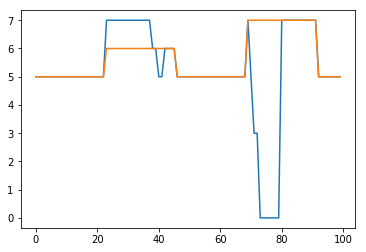

In [20]:
plt.figure()
plt.plot(y_pred[:100])
plt.plot(y_true[:100])
plt.show()

In [28]:
y_pred2 = np.zeros((int(len(y_pred)/23)))
y_true2 = np.zeros((int(len(y_pred)/23)))
y_true = np.argmax(Y_test, axis=1)

ind = 0
for i in range (0,len(y_pred), 23):
    (values,counts) = np.unique(y_pred[i:i+23],return_counts=True)
    c = np.argmax(counts)
    y_pred2[ind] = values[c]
    y_true2[ind] = y_true[i]
    ind = ind+1

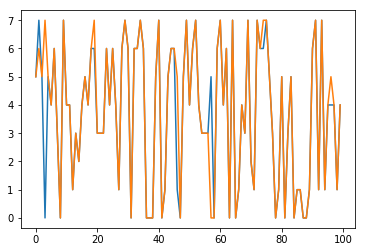

In [22]:
plt.figure()
plt.plot(y_pred2[:100])
plt.plot(y_true2[:100])
plt.show()

In [29]:
cf_matrix = confusion_matrix(y_true2, y_pred2)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true2, y_pred2, average=None)*100)*0.01
accuracy = accuracy_score(y_true2, y_pred2)

print('the mean-f1 score: {:.2f}'.format(np.mean(class_wise_f1)))
print('accuracy is: {:.2f}'.format(accuracy))

[[326   4   0   9   3   7   8   1]
 [  8 288   0   1   1   0   1   1]
 [  0   2  96   0   1   0   0   0]
 [  6   5   0 297   0   0   1   0]
 [  0   0   1   3 366   3   2   0]
 [  1   4   1   2   4 281   0   0]
 [  7   3   0   2   1   4 325  12]
 [ 14   4   0   0   0   5  30 256]]
the mean-f1 score: 0.93
accuracy is: 0.93


In [30]:
print(y_pred2.shape)
y_pred2 = np.int8(y_pred2) + 1
y_pred2 = y_pred2.repeat(6000).reshape(-1,6000)
print(y_pred2.shape)

y_true = np.int8(data['arr_20'] )
y_true = y_true[-2397:,:] #test = -2397:, val = 1739
#y_true = y_true[:1739,:]
print(y_true.shape)

out_path='/home/sandeep/storage/HASCA-Workshop/Vikranth/Predictions/Final_60/'

# data file with all the 16310 frames: 'Data_16310.npz'
# data file with only 1000 frames: 'Data_1000.npz'

out_file='bid6_94'
np.save(out_path + out_file, y_pred2)

y_true = y_true.reshape(-1)
y_pred2 = y_pred2.reshape(-1)
print(y_true.shape)
print(y_pred2.shape)
cf_matrix = confusion_matrix(y_true, y_pred2)
print(cf_matrix)
class_wise_f1 = f1_score(y_true, y_pred2, average=None)
accuracy = accuracy_score(y_true, y_pred2)

print('the mean-f1 score: {:.6f}'.format(np.mean(class_wise_f1)))
print('accuracy is: {:.6f}'.format(accuracy))

y_pred2 = np.zeros((int(len(y_pred)/23)*2))
y_true2 = np.zeros((int(len(y_pred)/23)*2))
ind = 0
for i in range (0,len(y_pred), 23):
    (values,counts) = np.unique(y_pred[i:i+14],return_counts=True)
    c = np.argmax(counts)
    y_pred2[ind] = values[c]
    (values,counts) = np.unique(y_true[i:i+14],return_counts=True)
    c = np.argmax(counts) 
    y_true2[ind] = values[c]
    (values,counts) = np.unique(y_pred[i+10:i+23],return_counts=True)
    c = np.argmax(counts)
    y_pred2[ind+1] = values[c]
    (values,counts) = np.unique(y_true[i+10:i+23],return_counts=True)
    c = np.argmax(counts)
    y_true2[ind+1] = values[c]
    ind = ind+2

print(y_pred2.shape)
y_pred2 = np.int8(y_pred2) + 1
y_pred2 = y_pred2.repeat(3000).reshape(-1,6000)
print(y_pred2.shape)

y_true = np.int8(data['arr_20'] )
y_true = y_true[-2397:,:] #test = -2397:, val = 1739
#y_true = y_true[:1739,:]
print(y_true.shape)

out_path='/home/sandeep/storage/HASCA-Workshop/Vikranth/Predictions/Final_30/'

# data file with all the 16310 frames: 'Data_16310.npz'
# data file with only 1000 frames: 'Data_1000.npz'

out_file='bid6_94'
np.save(out_path + out_file, y_pred2)

y_true = y_true.reshape(-1)
y_pred2 = y_pred2.reshape(-1)
print(y_true.shape)
print(y_pred2.shape)
cf_matrix = confusion_matrix(y_true, y_pred2)
print(cf_matrix)
class_wise_f1 = f1_score(y_true, y_pred2, average=None)
accuracy = accuracy_score(y_true, y_pred2)

print('the mean-f1 score: {:.6f}'.format(np.mean(class_wise_f1)))
print('accuracy is: {:.6f}'.format(accuracy))

(2397,)
(2397, 6000)
(2397, 6000)
(14382000,)
(14382000,)
[[2009366   27356    2528   15899   19409   18823   39840    4337]
 [  26283 1756976    4559    7421    2437       0    3330    5540]
 [      0   13902  575174       0    1324       0       0       0]
 [  14156   18902    2538 1844168     851     519     623       0]
 [      0    2536    1037    5454 2202592   18000   12000       0]
 [   7170   14935    2164    8710   23387 1707416       0       0]
 [  36530   11615       0    2348    6000   24687 1961143   72000]
 [  78495   13778       0       0       0   30555  185064 1538123]]
the mean-f1 score: 0.947555
accuracy is: 0.945276
(4794,)
(2397, 6000)
(2397, 6000)
(14382000,)
(14382000,)
[[2024813   17228       0    9937   31409   15391   38062     718]
 [  42104 1742608    4559    3138    2901    4790    3330    3116]
 [    472   10902  576404     462    1324     836       0       0]
 [  27920    2881       0 1842808    2704    4821     623       0]
 [   3000       0    1037    

In [24]:
model.save('Conv_lstm_bid6_94')